<a href="https://colab.research.google.com/github/marcomorigi95/Spam_detection/blob/main/Morigi_Marco_Spam_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Overview

The main objective is to identify spam emails to subsequently conduct in-depth content analysis with a focus on spam emails to better understand the associated trends, content and behaviors. These information will be used to improve the security of corporate communications and refine anti-spam filters.

The project will offer a complete analysis of the received emails, with a particular focus on the identification of spam emails and the analysis of their content.
Thanks to topic segmentation and semantic analysis, the company will be able to significantly improve its anti-spam filters and gain insights into the most relevant content, as well as optimize the management of corporate communications by extracting key information from legitimate emails.

This solution will increase the security of communications and improve business decision-making processes, generating a competitive advantage in the industry.

## Achievements

- **Improved anti-spam filtering**: An efficient classifier allows to significantly reduce the volume of unwanted emails reaching the mailbox, optimizing the management of corporate communications.

- **In-depth content analysis**: The identification of the main topics covered in spam emails allows to obtain valuable information on trends, themes and recurring patterns, enhancing cybersecurity strategies.

- **Heterogeneity assessment**: The semantic distance between topics allows to understand the diversity of spam contents, useful to optimize defenses against a wide range of attacks.

- **Organization identification**: The extraction of organizations from legitimate emails can be exploited to improve business intelligence processes and better manage communications with customers and partners.


## Workflow

- EDA of raw emails
- EDA of preprocessed emails
- Email classification models
- Topic Modeling LDA and Topic Distance
- NER
- Testing
- Conclusion

# Libraries

In [ ]:
# ----------------------------------------
# Data Handling and Preprocessing Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import time
from collections import Counter

# ----------------------------------------
# File Handling
# ----------------------------------------
import os
import pickle
import zipfile
import gdown
from google.colab import drive

#---------------------------------------
# NLP Libraries
#---------------------------------------
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# ----------------------------------------
# Visualization Libraries
# ----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ----------------------------------------
# ML Preprocessing and Feature Engineering
# ----------------------------------------
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

# ----------------------------------------
# Model Evaluation and Metrics
# ----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# ----------------------------------------
# Deep Learning Libraries
# ----------------------------------------
import keras
import tensorflow
import tensorflow as tf
from keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model

# ----------------------------------------
# LDA
# ----------------------------------------
!pip install pyLDAvis
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis.gensim_models
import gensim.corpora as corpora
from pprint import pprint

# ----------------------------------------
# NER
# ----------------------------------------
# !python -m spacy download en_core_web_trf
import spacy
import spacy.displacy as displacy

# ----------------------------------------
# Avoid Warnings
# ----------------------------------------
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 681.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


# Utils

In [ ]:
def get_email_lengths(df, condition):
    """
    Calculate the length (in words) of email text based on a specified condition.

    This function filters the comments in the DataFrame based on the given condition ('ham', 'spam', or 'both'),
    and then returns the length of each comment as the number of words.

    Args:
        df (pandas.DataFrame): The DataFrame containing the text data and the labels.
        condition (str): The condition to filter the comments by. It can be one of the following:
                         - 'ham': for ham emails
                         - 'spam': for spam emails
                         - 'both': for both emails

    Returns:
        pandas.Series: A Series containing the word lengths of the filtered emails.

    Raises:
        ValueError: If the condition is not one of 'ham', 'spam', or 'both'.
    """
    # Conditions for filtering the text
    condition_map = {
        "ham": df[df['label_num'] == 0]['text'],
        "spam": df[df['label_num'] == 1]['text'],
        "both": df['text']
    }

    if condition not in condition_map:
        raise ValueError("Condition must be one of 'ham', 'spam', or 'both'")

    return condition_map[condition].apply(lambda x: len(x.split()))

In [ ]:
def annotate_percentiles(ax, data, column_index):
    """
    Annotate the percentiles (25th, median, 75th) on a box plot.

    This function annotates the 25th percentile, median, and 75th percentile values on the provided axis
    of a box plot.

    Args:
        ax (matplotlib.axes.Axes): The axis object of the box plot where annotations will be placed.
        data (pandas.Series): The data to extract percentiles from.
        column_index (int): The index of the column in the box plot for positioning the annotations.

    Returns:
        None: This function modifies the axis by adding annotations.
    """
    q1 = data.quantile(0.25)
    median = data.quantile(0.50)
    q3 = data.quantile(0.75)

    ax.annotate(f'25th: {q1:.1f}', xy=(column_index + 1, q1), xytext=(column_index + 1.1, q1),
                fontsize=8, color='blue')
    ax.annotate(f'Median: {median:.1f}', xy=(column_index + 1, median), xytext=(column_index + 1.1, median),
                fontsize=8, color='green')
    ax.annotate(f'75th: {q3:.1f}', xy=(column_index + 1, q3), xytext=(column_index + 1.1, q3),
                fontsize=8, color='red')

In [ ]:
def box_plot_comment(df, show_quantile=True, show_outliers=True):
    """
    Create and display a box plot for text lengths based on ham vs spam.

    This function generates a box plot that visualizes the distribution of email lengths for ham and spam emails.
    The percentiles (25th, median, 75th) can be annotated on the plot, and outliers can be optionally shown.

    Args:
        df (pandas.DataFrame): The DataFrame containing the emails and labels.
        show_quantile (bool, optional): If True, the percentiles will be annotated on the plot. Default is True.
        show_outliers (bool, optional): If True, outliers will be shown on the box plot. Default is True.

    Returns:
        None: Displays the box plot of text lengths for ham and spam emails.
    """
    # Create a DataFrame for text lengths based on conditions
    boxplot_lengths_df = pd.DataFrame({
        'ham': get_email_lengths(df, "ham"),
        'spam': get_email_lengths(df, "spam")
    })

    # Create the box plot
    ax = boxplot_lengths_df.plot.box(figsize=(10, 6), showfliers=show_outliers)
    plt.ylabel("E-mail text lenghts")

    if show_quantile:
        # Annotate percentiles for each category
        for i, column in enumerate(boxplot_lengths_df.columns):
            annotate_percentiles(ax, boxplot_lengths_df[column], i)

    plt.title("Text Length Distribution")
    plt.ylabel("Text Length")
    plt.show()


In [ ]:
def get_words_by_frequency(text_series, n=20, most_common=True):
    """
    Get the most or least common words and their frequencies from a series of text data.

    This function calculates the frequency of words across the provided text data and returns either the
    most common or least common words, depending on the `most_common` flag.

    Args:
        text_series (pd.Series): A pandas Series containing the text data.
        n (int, optional): The number of most or least common words to return. Default is 20.
        most_common (bool, optional): If True, returns the most common words; if False, returns the least common words. Default is True.

    Returns:
        dict: A dictionary where keys are words and values are their frequencies.
    """
    # Get word frequency count
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)

    # Return most common or least common words based on the flag
    return dict(word_freq.most_common(n) if most_common else word_freq.most_common()[:-n-1:-1])


In [ ]:
def plot_word_frequency(df, n=20, most_common=True):
    """
    Plot the most or least common words for ham and spam email.

    This function visualizes the frequency of words in ham and spam emails separately. It generates
    bar plots for the most or least common words based on the `most_common` flag, comparing the two categories.

    Args:
        df (pandas.DataFrame): A DataFrame containing the text data and labels.
        n (int, optional): The number of most or least common words to plot. Default is 20.
        most_common (bool, optional): If True, plots the most common words; if False, plots the least common words. Default is True.
    """
    # Define a helper function to process and plot frequency for a given condition
    def plot_category(axis, text_data, title):
        words_freq = get_words_by_frequency(text_data, n=n, most_common=most_common)
        axis.bar(words_freq.keys(), words_freq.values())
        axis.set_title(title)
        axis.set_xlabel("Words")
        axis.set_ylabel("Frequencies")
        axis.tick_params(axis='x', rotation=45)

    # Filter non-toxic and toxic comments
    filtered_text_ham = df[df['label_num'] == 0]['text']
    filtered_text_spam =df[df['label_num'] == 1]['text']

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    plot_category(axes[0], filtered_text_ham, f"{'Most' if most_common else 'Least'} common words for Ham emails")
    plot_category(axes[1], filtered_text_spam, f"{'Most' if most_common else 'Least'} common words for Spam emails")

    plt.tight_layout()
    plt.show()


In [ ]:
# This cell is for the final testing part, ingore it.
custom_stop_words = {
                    "subject","www","http","etc","ect","cc","com","get","may",
                    "nbsp", "aling", "css", "amp", "jpg", "jpeg","png", "fyi",
                    "arial", "font", "pnbsp", "cellpadding", "cellspacing", "bgcolor",
                    "htmlimg", "colspan", "tdimg", "width", "height", "href", "src",
                    "center", "align", "gif", "charset", "rowspan", "index",
                    "color", "ascii", "cst", "tue", "fri","wed","sun","mon","thu",
                    "html", "head", "title", "base", "link", "meta", "style", "body",
                    "header", "nav", "section", "article", "aside", "footer", "address",
                    "h1", "h2", "h3", "h4", "h5", "h6", "p", "hr", "pre", "blockquote",
                    "ol", "ul", "li", "dl", "dt", "dd", "figure", "figcaption", "div",
                    "a", "em", "s", "cite", "q", "dfn", "abbr", "data", "rp", "bdi",
                    "code", "var", "samp", "kbd", "sub", "sup","mark", "ruby", "rt",
                    "bdo", "span", "br", "wbr", "tr", "td", "th", "source", "track",
                    "img", "map", "area", "canvas", "picture", "audio", "video", "tfoot",
                    "iframe", "embed", "object", "param","script", "noscript", "template",
                    "ins", "del","table", "caption", "colgroup", "col", "tbody", "thead",
                    "form", "label", "input", "button", "select", "datalist", "optgroup",
                    "textarea", "output", "meter", "fieldset", "legend", "details"
}

stop_word = set(stopwords.words('english'))
stop_word.update(custom_stop_words)

In [ ]:
class TextCleaner(BaseEstimator, TransformerMixin):
    """
    A custom transformer for cleaning and preprocessing text data.

    This class implements several operations to clean and preprocess email/text data:
    - Lowercasing the text.
    - Removing specific unwanted keywords, URLs, email addresses, and non-alphabetic symbols.
    - Optionally removing stopwords, applying lemmatization, and handling named entity recognition (NER) tasks.
    - Removing short tokens (length <= 2), unless they are important symbols (e.g., commas or periods).
    - Normalizing spaces to ensure proper spacing between words.

    When the `ner` flag is enabled, additional preprocessing steps are applied:
    - Removes spaces before colons in headers like 'subject:', 'from:', etc.
    - Extracts the core content of the "subject:" line, removing phrases like "forwarded by".
    - Strips unnecessary metadata and focuses on the main message content.

    Additionally, a list of unwanted keywords (e.g., 'http', 'href', 'src') is removed from the text using regular
    expressions. This helps eliminate irrelevant terms often found in email or web content, such as HTML tags and
    styling attributes, while preserving the structure of the core content.

    Args:
        lemming (bool): If True, applies lemmatization to words.
        ner (bool): If True, applies additional preprocessing steps related to named entity recognition (NER),
                    such as removing spaces before colons in specific headers and filtering the subject line.
        stop_words (list or None): A list of stopwords to remove from the text. If None, no stopwords are removed.

    Methods:
        fit(X, y=None):
            Returns the transformer instance itself. This method does not perform any fitting, as no training is needed.

        clean_text(email_text):
            Cleans and preprocesses the input email/text. Applies all preprocessing steps including optional NER, stopword removal, lemmatization, and filtering of unwanted keywords.

        transform(X, y=None):
            Transforms the input data by cleaning the text.
            Works for both strings and DataFrames (operating on the 'text' column).
    """

    def __init__(self, lemming=False, ner=False, stop_words=None):
        self.lemming = lemming
        self.ner = ner
        self.stop_words = stop_words
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        """Returns the transformer instance itself."""
        return self

    def clean_text(self, email_text):
        """
        Cleans and preprocesses the input text.

        Args:
            email_text (str): The text (usually an email) to be cleaned and preprocessed.

        Returns:
            str: The cleaned and preprocessed text.
        """
        email_text = str(email_text).lower()

        if self.ner:
            # Remove spaces before colons for specific headers
            email_text = re.sub(r'\b(subject|from|to|cc|date|re)\s*:', r'\1:', email_text)

            # Process subject line if present
            subject_match = re.search(r'subject:.*', email_text)
            if subject_match:
                subject_start = subject_match.start()
                subject_text = email_text[subject_start:]

                # Handle "forwarded by" within the subject line
                forwarded_match = re.search(r'forwarded by', subject_text)
                if forwarded_match:
                    forwarded_start = forwarded_match.start()
                    email_text = subject_text[:forwarded_start].strip()
                else:
                    email_text = subject_text.strip()
            else:
                email_text = email_text.strip()

        # Clean out unwanted keywords
        keywords = ["www", "http", "tdimg", "width", "height", "href", "nbsp", "align", "gif", "charset",
                    "rowspan", "index", "pnbsp", "html", "colspan", "src", "center", "align", "color", "fontfont", "fff"]
        pattern = r'\b\w*(' + '|'.join(keywords) + r')\w*\b'
        email_text = re.sub(pattern, ' ', email_text)

        # Further clean out URLs, email addresses, mentions, digits, and non-alphabetic symbols
        if self.ner:
            email_text = re.sub(r'http\S+|<.*?>|@\w+|\d+|[^a-zA-Z\s.,-]', ' ', email_text)
        else:
            email_text = re.sub(r'http\S+|<.*?>|@\w+|\n|#\w+|\d+|[^a-zA-Z0-9\s]', ' ', email_text)

        # Remove stopwords if provided
        if self.stop_words is not None:
            email_text = " ".join([word for word in email_text.split() if word not in self.stop_words])

        # Apply lemmatization if needed
        if self.lemming:
            email_text = " ".join([self.lemmatizer.lemmatize(word) for word in email_text.split()])

        # Remove short tokens (length <= 2), unless they are important symbols (.,)
        email_text = " ".join([word for word in email_text.split() if len(word) > 2 or word in [",", "."]])

        # Normalize spaces to ensure proper spacing
        email_text = re.sub(r'\s+', ' ', email_text).strip()

        return email_text

    def transform(self, X, y=None):
        """
        Transforms the input data by cleaning the text.

        If the input is a string, it processes the string directly. If the input is a DataFrame,
        it operates on the 'text' column to clean the text.

        Args:
            X (str or pd.DataFrame): The data to be transformed. If a DataFrame, it is assumed to have a column 'text'.
            y (optional): Ignored, only for compatibility with scikit-learn pipelines.

        Returns:
            str or pd.DataFrame: The transformed text data, either as a string or a DataFrame with cleaned text.
        """
        if isinstance(X, str):
            return self.clean_text(X)

        X["text"] = X["text"].apply(lambda x: self.clean_text(x))
        return X


In [ ]:
class DropUnwantedText(BaseEstimator, TransformerMixin):
    """
    A custom transformer for removing unwanted text from a DataFrame or single string.

    This class implements two main operations to clean text data:
    - Removing duplicate comments (if the input is a DataFrame).
    - Filtering out rows based on text length (keeping only comments with a length of 3 or more characters).

    Args:
        None: This transformer does not require any parameters during initialization.

    Methods:
        fit(X, y=None):
            Returns the transformer instance itself. This method does not perform any fitting, as no training is needed.

        drop_duplicates_text(dataframe):
            Removes duplicate comments from the DataFrame or returns the string as is if input is a string.

        filter_by_length(dataframe):
            Filters out rows where the text length is less than 3 characters, or returns the string as is if input is a string.

        transform(X, y=None):
            Transforms the input data by dropping duplicates and filtering by text length.
            Works for both DataFrames (operating on the 'text' column) and single strings.

    """

    def __init__(self):
        """Initializes the transformer without any specific parameters."""
        pass

    def fit(self, X, y=None):
        """Returns the transformer instance itself."""
        return self

    def drop_duplicates_text(self, dataframe):
        """
        Removes duplicate comments from the input DataFrame.

        Args:
            dataframe (pd.DataFrame or str): The data from which duplicates need to be removed.

        Returns:
            pd.DataFrame or str: The DataFrame with duplicates removed or the original string if the input was a string.
        """
        if isinstance(dataframe, str):
            return dataframe  # If it's a string, just return it as is
        return dataframe.drop_duplicates()

    def filter_by_length(self, dataframe):
        """
        Filters rows by the length of the text in the 'text' column.

        Args:
            dataframe (pd.DataFrame or str): The DataFrame to be filtered or a single string to process.

        Returns:
            pd.DataFrame or str: The DataFrame filtered by text length, or the original string if the input was a string.
        """
        if isinstance(dataframe, str):
            return dataframe  # If it's a string, just return it as is
        return dataframe[dataframe['text'].str.split().str.len() >= 3]

    def transform(self, X, y=None):
        """
        Transforms the input data by dropping duplicates and filtering by text length.

        If the input is a string, it processes the string directly. If the input is a DataFrame,
        it operates on the 'text' column to drop duplicates and filter by text length.

        Args:
            X (str or pd.DataFrame): The data to be transformed. If a DataFrame, it is assumed to have a column 'text'.
            y (optional): Ignored, only for compatibility with scikit-learn pipelines.

        Returns:
            str or pd.DataFrame: The transformed text data, either as a string or a DataFrame with filtered text.
        """
        if isinstance(X, str):
            return self.filter_by_length(self.drop_duplicates_text(X))

        df = self.drop_duplicates_text(X)
        df = self.filter_by_length(df)
        return df


In [ ]:
class TestSplit(BaseEstimator, TransformerMixin):
    """
    A custom transformer for splitting a DataFrame into features (X) and labels (y).

    This class is used to separate the 'text' column as the feature set (X)
    and the remaining columns (excluding 'text' and 'label_num') as the label set (y).

    Args:
        None: This transformer does not require any parameters during initialization.

    Methods:
        fit(X, y=None):
            Returns the transformer instance itself. This method does not perform any fitting, as no training is needed.

        df_split_text(X):
            Splits the input DataFrame into feature (X) and label (y) sets.
            The 'text' column is used as features, and all other columns except 'text' and 'label_num' are used as labels.

        transform(X, y=None):
            Transforms the input DataFrame by calling `df_split_text`, returning the feature and label sets.
    """

    def __init__(self):
        """Initializes the transformer without any specific parameters."""
        pass

    def fit(self, X, y=None):
        """Returns the transformer instance itself."""
        return self

    def df_split_text(self, X):
        """
        Splits the input DataFrame into features and labels.

        Args:
            X (pd.DataFrame): The DataFrame to split. Expected to contain a 'text' column and other label columns.

        Returns:
            pd.DataFrame: A DataFrame containing the 'text' column (features).
            pd.DataFrame: A DataFrame containing the remaining columns (labels), excluding 'text' and 'label_num'.
        """
        X_split = X["text"]
        y_split = X["label_num"]
        return X_split, y_split

    def transform(self, X, y=None):
        """
        Transforms the input DataFrame by splitting it into features (X) and labels (y).

        Args:
            X (pd.DataFrame): The DataFrame to split, expected to contain a 'text' column and other label columns.
            y (optional): Ignored, only for compatibility with scikit-learn pipelines.

        Returns:
            pd.DataFrame: A tuple where the first element is the 'text' column (features),
                          and the second element contains the remaining columns (labels).
        """
        X_split, y_split = self.df_split_text(X)

        return X_split, y_split


In [ ]:
class PreprocessTfidfVectorizer(BaseEstimator, TransformerMixin):
    """
    A custom transformer for applying TF-IDF vectorization to text data.

    This class is designed to convert raw text into TF-IDF weighted feature vectors using Scikit-learn's TfidfVectorizer.

    Args:
        max_features (int, optional): The maximum number of features to keep in the TF-IDF matrix. Default is None, meaning no limit.
        ngram_range (tuple, optional): The range of n-values for the n-grams to extract. Default is (1, 1), which means only unigrams.
        min_df (float or int, optional): The minimum document frequency for features.
                                          Default is 1, meaning no feature is removed based on document frequency.
        max_df (float or int, optional): The maximum document frequency for features.
                                          Default is 1.0, meaning no feature is removed based on document frequency.

    Methods:
        fit(X, y=None):
            Fits the TfidfVectorizer on the training data.

        transform(X, y=None):
            Transforms the text data into TF-IDF feature vectors.

        fit_transform(X, y=None):
            Fits the TfidfVectorizer and transforms the data in a single step.
    """

    def __init__(self, max_features=None, ngram_range=(1, 1), min_df=1, max_df=1.0):
        """Initializes the TF-IDF vectorizer with the specified configuration."""
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        # Initialize the TfidfVectorizer
        self.vectorizer = TfidfVectorizer(max_features=self.max_features,
                                          ngram_range=self.ngram_range,
                                          min_df=self.min_df,
                                          max_df=self.max_df)

    def fit(self, X, y=None):
        """
        Fits the TfidfVectorizer on the training data.

        Args:
            X (tuple): A tuple where X[0] contains the text data to be vectorized.
            y (optional): Labels (not used in this method).

        Returns:
            self: The fitted vectorizer instance.
        """
        # Extract the text data from the tuple (X[0] contains the text data)
        text_data = X[0]

        self.vectorizer.fit(text_data)
        return self

    def transform(self, X, y=None):
        """
        Transforms the text data into TF-IDF feature vectors.

        Args:
            X (tuple): A tuple where X[0] contains the text data and X[1] contains the labels.
            y (optional): Labels (not used in this method).

        Returns:
            tuple: A tuple containing:
                - The transformed text data as TF-IDF feature vectors.
                - The unchanged labels (y_split from TestSplit).
        """

        # Extract the text data from the tuple (X[0] contains the text data)
        text_data = X[0]

        # Transform the text data to TF-IDF feature vectors
        X_tfidf = self.vectorizer.transform(text_data)

        # Return the transformed X (TF-IDF vectors) and the unchanged y
        return X_tfidf, X[1]

    def fit_transform(self, X, y=None):
        """
        Fits and transforms the data in a single step.

        Args:
            X (tuple): A tuple where X[0] contains the text data to be vectorized and X[1] contains the labels.
            y (optional): Labels (not used in this method).

        Returns:
            tuple: A tuple containing:
                - The transformed text data as TF-IDF feature vectors.
                - The unchanged labels.
                - The fitted vectorizer instance.
        """
        self.fit(X, y)
        X_tfidf, y = self.transform(X, y)
        return X_tfidf, y


In [ ]:
class PreprocessVectorizer(BaseEstimator, TransformerMixin):
    """
    A custom transformer for vectorizing text data into sequences of indices using TensorFlow's TextVectorization layer.

    This class is designed to convert raw text into integer sequences using either character-level or word-level tokenization.
    The text data is transformed into sequences that can be fed into neural networks or other machine learning models.

    Args:
        vocabulary_size (int, optional): The maximum number of tokens to keep in the vocabulary. Default is None, meaning no limit.
        output_sequence_length (int, optional): The desired length of the output sequences.
                                                Sequences will be padded or truncated to this length. Default is 100.
        token_level (str, optional): Specifies the level of tokenization. Can be 'word' or 'character'. Default is 'word'.

    Methods:
        fit(X, y=None):
            Fits the TextVectorization layer on the training data.
            It prepares the vectorizer by adapting it to the input text data.

        transform(X, y=None):
            Transforms the text data into sequences of indices.
            This method uses the fitted vectorizer to convert the text into a sequence format suitable for ML models.

        fit_transform(X, y=None):
            Fits the vectorizer and transforms the data in a single step.
    """

    def __init__(self, vocabulary_size=None, output_sequence_length=100, token_level='word'):
        """Initializes the vectorizer with the specified configuration."""
        self.vocabulary_size = vocabulary_size
        self.output_sequence_length = output_sequence_length
        self.token_level = token_level
        self.vectorizer = None

    def fit(self, X, y=None):
        """
        Fits the TextVectorization layer on the training data.

        Args:
            X (tuple): A tuple where X[0] contains the text data to be vectorized.
            y (optional): Labels (not used in this method).

        Returns:
            self: The fitted vectorizer instance.
        """
        # Extract the text data from the tuple (X[0] contains the text data)
        text_data = X[0]

        if self.token_level == 'character':
            self.vectorizer = TextVectorization(
                max_tokens=self.vocabulary_size,
                split='character',
                output_mode='int',
                output_sequence_length=self.output_sequence_length
            )
        elif self.token_level == 'word':
            self.vectorizer = TextVectorization(
                max_tokens=self.vocabulary_size,
                output_mode='int',
                output_sequence_length=self.output_sequence_length
            )
        else:
            raise ValueError("Invalid token_level. Choose 'word' or 'character'.")

        self.vectorizer.adapt(text_data)  # Apply adapt only here when fitting
        return self

    def transform(self, X, y=None):
        """
        Transforms the text data into sequences of indices.

        Args:
            X (tuple): A tuple where X[0] contains the text data and X[1] contains the labels.
            y (optional): Labels (not used in this method).

        Returns:
            tuple: A tuple containing:
                - The transformed text data as sequences of indices.
                - The unchanged labels (y_split from TestSplit).
        """
        if self.vectorizer is None:
            raise RuntimeError("Vectorizer is not fitted yet. Please call `fit` before `transform`.")

        # Extract the text data from the tuple (X[0] contains the text data)
        text_data = X[0]

        # Transform the text data (X) to sequences of indices
        X_seq = self.vectorizer(text_data)

        # Return the transformed X and the unchanged y
        return X_seq, X[1]

    def fit_transform(self, X, y=None):
        """
        Fits and transforms the data in a single step.

        Args:
            X (tuple): A tuple where X[0] contains the text data to be vectorized and X[1] contains the labels.
            y (optional): Labels (not used in this method).

        Returns:
            tuple: A tuple containing:
                - The transformed text data as sequences of indices.
                - The unchanged labels.
                - The fitted vectorizer instance.
        """
        self.fit(X, y)
        X_seq, y = self.transform(X, y)
        return X_seq, y, self.vectorizer


In [ ]:
class PreprocessText:
    """
    A preprocessing pipeline for cleaning, transforming, and vectorizing text data.

    This class combines several steps to process text data, including cleaning, filtering, splitting, and optional vectorization.
    The pipeline can handle various stages such as:
    - Text cleaning (lemmatization, stopword removal)
    - Dropping unwanted text (removing duplicates, filtering by text length)
    - Splitting the data into features (X) and labels (y)
    - Vectorizing the text (using word-level or character-level tokenization)

    Args:
        lemming (bool, optional): Whether to apply lemmatization. Default is False.
        stop_words (set, optional): A custom set of stopwords to remove. Default is None.
        vocabulary_size (int, optional): The maximum size of the vocabulary for the vectorizer. Must be specified if vectorizer is enabled.
        output_sequence_length (int, optional): The desired length of the output sequences (after padding/truncating). Default is 40.
        token_level (str, optional): The tokenization level, either 'word' or 'character'. Default is 'word'.
        vectorizer (bool, optional): Whether to apply vectorization (TextVectorization). Default is True.
        tfidf (bool, optional): Whether to apply TF-IDF vectorization. Default is False.
        max_features (int, optional): Maximum number of features for TF-IDF vectorization. Default is None.
        split (bool, optional): Whether to split the input data into features (X) and labels (y). Default is True.

    Methods:
        create_pipeline():
            Creates the preprocessing pipeline, including text cleaning, unwanted text removal, data splitting, and vectorization if enabled.

        fit(df):
            Fits the pipeline on the training data and transforms the input DataFrame.

        transform(df):
            Transforms the input DataFrame using the fitted pipeline without fitting.

        fit_transform(df):
            Fits and transforms the input DataFrame in a single step.
    """

    def __init__(self, lemming=False, stop_words=None, vocabulary_size=None,
                 output_sequence_length=None, token_level='word', max_features=None,
                 tfidf=False, vectorizer=False, split=True):
        """
        Initializes the preprocessing pipeline with the specified configuration.

        Args:
            lemming (bool): Whether to apply lemmatization. Default is True.
            stop_words (set): Stopwords to remove. Default is None.
            vocabulary_size (int): The size of the vocabulary for vectorization. Default is None.
            output_sequence_length (int): The desired length of the output sequences. Default is 40.
            token_level (str): Tokenization level, either 'word' or 'character'. Default is 'word'.
            vectorizer (bool): Whether to apply vectorization. Default is True.
            tfidf (bool): Whether to apply TF-IDF vectorization. Default is False.
            max_features (int): Maximum number of features for TF-IDF vectorization. Default is None.
            split (bool): Whether to split the input data into features (X) and labels (y). Default is True.
        """
        self.lemming = lemming
        self.stop_words = stop_words
        self.vocabulary_size = vocabulary_size
        self.output_sequence_length = output_sequence_length
        self.token_level = token_level
        self.max_features = max_features
        self.vectorizer = vectorizer
        self.tfidf = tfidf
        self.split = split
        self.pipeline = None

        # Validate parameters if vectorizer is True
        if self.vectorizer:
            if self.vocabulary_size is None:
                raise ValueError("vocabulary_size must be specified when vectorizer=True.")
            if not isinstance(self.output_sequence_length, int) or self.output_sequence_length <= 0:
                raise ValueError("output_sequence_length must be a positive integer when vectorizer=True.")
            if self.token_level not in ['word', 'character']:
                raise ValueError("token_level must be either 'word' or 'character' when vectorizer=True.")

        if self.tfidf:
          if self.max_features is None:
                raise ValueError("max_features must be specified when tfidf=True.")

    def create_pipeline(self):
        """
        Creates the preprocessing pipeline with the required steps.

        This method sets up the steps in the pipeline, including text cleaning, unwanted text removal,
        data splitting, and optional text vectorization.
        """
        steps = [
            # Step 1: Apply TextCleaner to the 'text' column
            ('text_cleaner', TextCleaner(self.lemming, self.stop_words)),

            # Step 2: Drop unwanted text (remove duplicates and filter by length)
            ('drop_unwanted_text', DropUnwantedText()),
        ]

        # Step 3: Split the data into X (features) and y (target labels)
        if self.split:
          steps.append(('split', TestSplit()))

        # Optional Step 4: Apply tfidf if tfidf is enabled
        if self.tfidf:
          steps.append(('tfidf', PreprocessTfidfVectorizer(max_features=self.max_features)))

        # Optional Step 5: Apply TextVectorizer if vectorizer is enabled
        if self.vectorizer:
            steps.append(('text_vectorizer', PreprocessVectorizer(self.vocabulary_size,
                                                                  self.output_sequence_length,
                                                                  self.token_level)))

        self.pipeline = Pipeline(steps)

    def fit(self, df):
        """
        Fits the pipeline on the training data and transforms the input DataFrame.

        Args:
            df (pd.DataFrame): The input DataFrame to fit and transform.

        Returns:
            tuple: Transformed features and labels.
        """
        if self.pipeline is None:
            self.create_pipeline()
        return self.pipeline.fit_transform(df)

    def transform(self, df):
        """
        Transforms the input DataFrame using the fitted pipeline without fitting.

        Args:
            df (pd.DataFrame): The input DataFrame to transform.

        Returns:
            tuple: Transformed features and labels.
        """
        if self.pipeline is None:
            self.create_pipeline()
        return self.pipeline.transform(df)

    def fit_transform(self, df):
        """
        Fits and transforms the input DataFrame in a single step.

        Args:
            df (pd.DataFrame): The input DataFrame to fit and transform.

        Returns:
            tuple: Transformed features, labels, and the fitted vectorizer.
        """
        if self.pipeline is None:
            self.create_pipeline()
        return self.pipeline.fit_transform(df)


In [ ]:
def get_metrics(y_true, y_pred, model_name):
    """
    Calculates and returns evaluation metrics for a classification model.

    This function computes several metrics, including precision, recall, F1-score, accuracy, false positives (FP), and false negatives (FN)
    for the 'Spam' class (label 1) based on the true labels ('y_true') and predicted labels ('y_pred').

    The metrics are extracted from the confusion matrix and a classification report. The function also includes the model's name in the output.

    Args:
        y_true (array-like): True labels (ground truth).
        y_pred (array-like): Predicted labels from the model.
        model_name (str): The name of the model being evaluated.

    Returns:
        dict: A dictionary containing the following evaluation metrics for the 'Spam' class:
            - 'Model': The name of the model.
            - 'Precision': Precision for the 'Spam' class (rounded to two decimal places).
            - 'Recall': Recall for the 'Spam' class (rounded to two decimal places).
            - 'F1-Score': F1-Score for the 'Spam' class (rounded to two decimal places).
            - 'Accuracy': Overall accuracy of the model (rounded to two decimal places).
            - 'FP': False Positives for the 'Spam' class.
            - 'FN': False Negatives for the 'Spam' class.
    """
    # Calculate confusion matrix to extract false positives and false negatives
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    report = classification_report(y_true, y_pred, target_names=["Ham", "Spam"], output_dict=True)

    # Extract specific metrics for 'Spam' (label 1)
    spam_metrics = report["Spam"]

    # Add a row for the model's metrics
    return {
        'Model': model_name,
        'Precision': round(spam_metrics["precision"], 2),
        'Recall': round(spam_metrics["recall"], 2),
        'F1-Score': round(spam_metrics["f1-score"], 2),
        'Accuracy': round(accuracy_score(y_true, y_pred),2),
        'FP': fp,
        'FN': fn
    }


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Evaluates the performance of a classification model using the provided training and test data.

    This function trains the model on the training data, generates predicted probabilities on the test data,
    and then converts the probabilities into binary labels based on the specified threshold. It then calculates
    several evaluation metrics (such as precision, recall, F1-score, accuracy, false positives, and false negatives)
    for the model using the true test labels and the predicted labels.

    Args:
        model (sklearn.base.ClassifierMixin): The classification model to be evaluated.
        X_train (array-like or pd.DataFrame): The training data used to train the model.
        y_train (array-like or pd.Series): The true labels for the training data.
        X_test (array-like or pd.DataFrame): The test data used to evaluate the model.
        y_test (array-like or pd.Series): The true labels for the test data.
        threshold (float, optional): The threshold for converting predicted probabilities to binary labels.
                                     Default is 0.5.

    Returns:
        dict: A dictionary containing various evaluation metrics for the model, including:
              - 'Model': The name of the model.
              - 'Precision': Precision for the 'Spam' class (rounded to two decimal places).
              - 'Recall': Recall for the 'Spam' class (rounded to two decimal places).
              - 'F1-Score': F1-Score for the 'Spam' class (rounded to two decimal places).
              - 'Accuracy': Overall accuracy of the model (rounded to two decimal places).
              - 'FP': False Positives for the 'Spam' class.
              - 'FN': False Negatives for the 'Spam' class.
    """
    model.fit(X_train, y_train)
    predictions_proba = model.predict_proba(X_test)
    predicted_labels = (predictions_proba[:, 1] > threshold).astype(int)

    # Collect and return the metrics for the model
    return get_metrics(y_test, predicted_labels, threshold, model.__class__.__name__)


In [ ]:
def mount_drive():
    """
    Mounts the Google Drive if it is not already mounted.
    """
    if not os.path.ismount('/content/drive'):
        drive.mount('/content/drive')
        print("Drive mounted successfully.")


In [ ]:
def download_file(file_id, destination):
    """
    Downloads a file from Google Drive to the specified destination if it is not already downloaded.

    Args:
        file_id (str): The Google Drive file ID.
        destination (str): The path where the file should be saved.
    """
    if not os.path.exists(destination):
        gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)


In [ ]:
def load_tokenizer(tokenizer_file):
    """
    Loads a tokenizer from the specified file.

    Args:
        tokenizer_file (str): The path to the tokenizer file.

    Returns:
        tokenizer: The loaded tokenizer object if successful, None if there's an error.
    """
    try:
        with open(tokenizer_file, 'rb') as f:
            tokenizer = pickle.load(f)
        return tokenizer
    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        return None

In [ ]:
def load_trained_model(model_file):
    """
    Loads a trained model from the specified file.

    Args:
        model_file (str): The path to the model file.

    Returns:
        model: The loaded trained model if successful, None if there's an error.
    """
    try:
        model = tf.keras.models.load_model(model_file)
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

In [ ]:
def preprocess_and_predict(test_text, tokenizer, model):
    """
    Preprocesses the input text, tokenizes it, and uses the model to make predictions.

    Args:
        test_text (str): The input text to be processed and predicted.
        tokenizer: The tokenizer to convert text to sequences.
        model: The trained model used for predictions.

    Returns:
        predictions: A numpy array containing the model's predictions.
    """
    cleaning_pipeline = Pipeline(steps=[
        ("cleaner", TextCleaner(lemming=True, stop_words=stop_word)),
        ("droptext", DropUnwantedText()),
    ])

    # Clean and tokenize the text
    test_text_cleaned = cleaning_pipeline.transform(test_text)
    test_sequence = tokenizer([test_text_cleaned])
    test_sequence_padded = pad_sequences(test_sequence.numpy(), maxlen=75)

    # Convert to tensor
    test_sequence_padded = tf.convert_to_tensor(test_sequence_padded, dtype=tf.float32)

    # Get model predictions
    predictions = model(test_sequence_padded).numpy().flatten()

    return predictions


In [ ]:
def initialize_resources():
    """
    Initializes and loads the necessary resources for the spam email detection pipeline.

    This function performs the following steps:
    1. Loads a pre-trained NLP model using spaCy (`en_core_web_sm`).
    2. Defines file IDs and destination paths for various required resources.
    3. Downloads the required files from Google Drive using their file IDs.
    4. Loads the tokenizer, trained model, LDA model, and id2word dictionary from the specified destinations.

    Resources:
        - NLP model (spaCy)
        - Tokenizer for text processing
        - Pre-trained spam detection model (Keras)
        - LDA (Latent Dirichlet Allocation) model for topic modeling
        - id2word dictionary for LDA model

    Returns:
        tuple: A tuple containing the following resources:
            - nlp (spacy.language): The loaded spaCy NLP model.
            - tokenizer (Tokenizer): The loaded tokenizer for text processing.
            - model (keras.Model): The loaded trained spam detection model.
            - lda (gensim.models.LdaMulticore): The loaded LDA model.
            - id2word (gensim.corpora.Dictionary): The loaded id2word dictionary for the LDA model.

    Raises:
        ValueError: If any of the resources fail to load or download.
    """

    # Load the NLP model
    nlp = spacy.load('en_core_web_sm')

    # Define file IDs and destination paths
    file_paths = {
        'tokenizer': {'id': '1qVVqY5PxIa7n6VUxIlAYxCoEAabzWHBr', 'destination': '/content/drive/MyDrive/tokenizer_spam_email.pkl'},
        'model': {'id': '10tr20dlmbRyCcmSvX8qUzqzSFcFyy7QH', 'destination': '/content/drive/MyDrive/model_spam.keras'},
        'lda_model': {'id': '1SkVRWuIDg0GipECbBthdRm9BFS9ip_id', 'destination': '/content/drive/MyDrive/lda_model.gensim'},
        'expElogbeta': {'id': '1muE__FKYZZJteS8QP89fn0ZeHYtEzXqI', 'destination': '/content/lda_model.gensim.expElogbeta.npy'},
        'lda_state': {'id': '1WOgaRvD7mW--hL3BLFgoEYPTRf6GuQRv', 'destination': '/content/lda_model.gensim.state'},
        'id2word': {'id': '1epv0ZR8yFQUSVIH10mUlhGa6iRyaJJqp', 'destination': '/content/drive/MyDrive/lda_model.gensim.id2word'}
    }

    # Download all necessary files
    for file in file_paths.values():
        download_file(file['id'], file['destination'])

    # Load resources
    tokenizer = load_tokenizer(file_paths['tokenizer']['destination'])
    model = load_trained_model(file_paths['model']['destination'])
    lda = gensim.models.LdaMulticore.load(file_paths['lda_model']['destination'])
    id2word = gensim.corpora.Dictionary.load(file_paths['id2word']['destination'])

    return nlp, tokenizer, model, lda, id2word

# EDA

Let's start with dataset download.

In [ ]:
URL = "https://github.com/ProfAI/natural-language-processing/blob/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv?raw=true"
df = pd.read_csv(URL)

## Raw e-mail

The analysis of the dataset without doing any preprocessing will be done.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


As can be noted, there are 4 colums and 5171 entries. It seems that there are no empty rows for now. Let's check in more detail the columns in order to understand if all of the them are useful for our goal.

In [ ]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


As you can see, the column "**Unnamed: 0**" seems to be some sort of unique identifier and therefore it is of no help to us for our purpose. Then we notice that the two columns "**label**" and "**label_num**" represent the same thing, that is if the email is spam (1) or ham (0), consequently we only need to keep one of the two. Before eliminating one of the two columns we check that there are no errors and both columns are congruent, that is, that there is no email labeled as spam and the corresponding **label_num** equal to 0 and viceversa.

In [ ]:
if all((label == {0: 'ham', 1: 'spam'}[num]) for label, num in zip(df['label'], df['label_num'])):
    print("All labels are correct.")
else:
    print("Some labels are incorrect.")


All labels are correct.


It looks like everything labels correctly. Now let's check if there are any duplicates.

In [ ]:
Counter(df.duplicated())

Counter({False: 5171})

At first glance, there appear to be no issues. However, we need to consider a few potential problems. The column **"Unnamed: 0"** may cause two emails to appear as distinct entries, even though they are actually the same, due to being mistakenly assigned different unique IDs. Additionally, the **"text"** column contains the actual content of the emails, and even a small difference, such as an extra space, could cause the system to treat them as separate. This issue will be analyzed in detail later.

Let's check what a random email from our database looks like.

In [ ]:
print(df["text"].iloc[420])

Subject: re : noms / actual flow for 4 / 09 / 01
we agree
" eileen ponton " on 04 / 10 / 2001 11 : 50 : 01 am
to : david avila / lsp / enserch / us @ tu , charlie stone / texas utilities @ tu , melissa
jones / texas utilities @ tu , hpl . scheduling @ enron . com , liz . bellamy @ enron . com
cc :
subject : noms / actual flow for 4 / 09 / 01
60 , 000 rate for 14 hours ( 9 : 00 am to 23 : 00 )
40 , 000 rate for 10 hours ( 23 : 00 to 9 : 00 am )
nom mcf mmbtu
51 , 667 47 , 673 48 , 960
btu = 1 . 027


As can be noted, there are many elements that do not add meaning for our purposes. In the case of email identification, having all these numbers and punctuation can be counterproductive in terms of model accuracy and computational cost. Later on, we will show how to properly handle this.

Percentages of ham and spam email.

In [ ]:
print("Percentage of e-mail by type:\n")
percentage_spam = (Counter(df["label"] == "spam")[1])/len(df)*100
print(f"Ham e-mail: {100-percentage_spam:.2f}%")
print(f"Spam e-mail: {percentage_spam:.2f}%")

Percentage of e-mail by type:

Ham e-mail: 71.01%
Spam e-mail: 28.99%


It seems that ham emails are present in greater quantities than spam emails hence there is a slight imbalance.

Let's check how long the total length of ham and spam emails is, to look for any features that can help us in training the models.

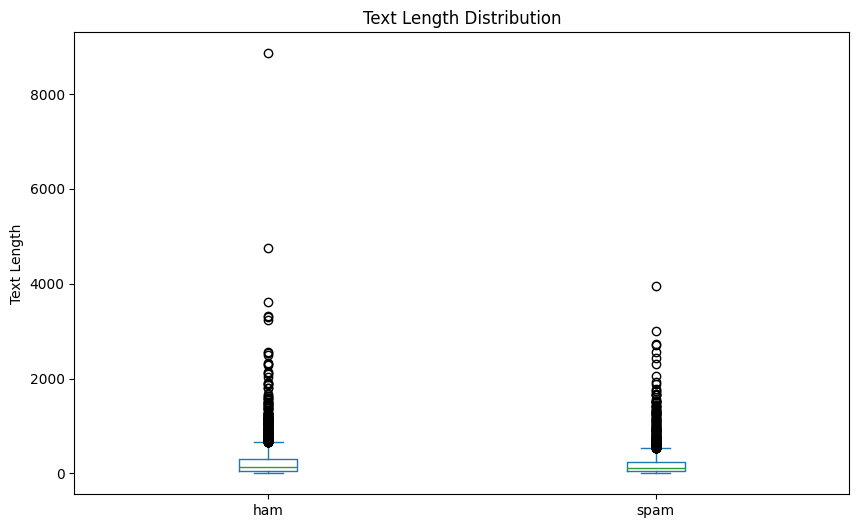

In [ ]:
box_plot_comment(df, show_quantile=False, show_outliers=True)

There is a fair amount of outliers, but given the nature of our study object, this is not too much of a problem. Let's analyze the boxplot without outliers to better notice the differences.

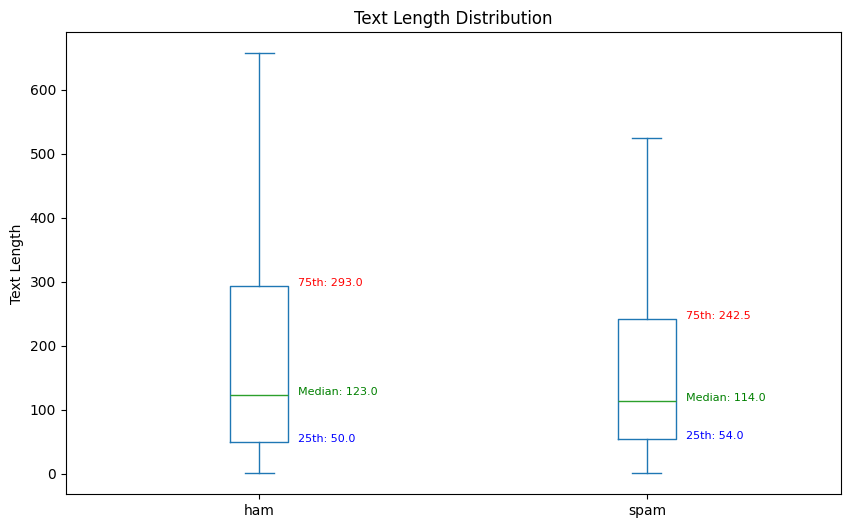

In [ ]:
box_plot_comment(df, show_quantile=True, show_outliers=False)

It seems that spam emails are also slightly shorter on median than ham emails.
As for the frequency of words present in the two types of emails, the following is noted.

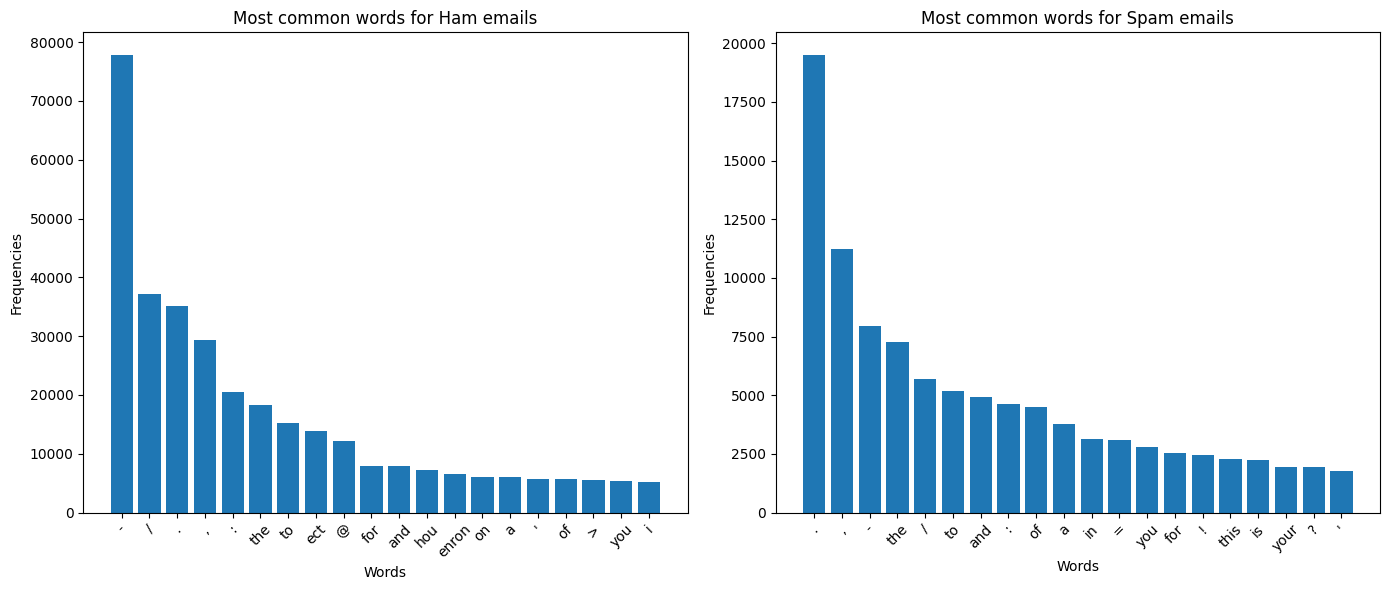

In [ ]:
plot_word_frequency(df, n=20, most_common=True)

Single characters such as (\ or :) do not add meaning to the email or do not allow you to distinguish the difference between a spam or ham email. We will see later how to handle them appropriately.

## Cleaned e-mail

Now let's explore the emails in more depth by applying the TextCleaner class to the column containing the text. This will allow us to remove the noise and the parts that do not interest us.

**Note**: Due to the way TextCleaner class is designed, it is possible to enable or disable different settings, because each part of the project will have different settings due to the different nature of the problems. These features will be further explained later on.

As mentioned before, let's start by removing the two columns which do not add information.

In [ ]:
df = df.drop(['Unnamed: 0', 'label'], axis=1)

After an analysis of the emails, many links to website and html tags were noticed. For this reason, it was decided to add to the classic stop words all the various html tags.

In [ ]:
custom_stop_words = {
                    "subject","www","http","etc","ect","cc","com","get","may",
                    "nbsp", "aling", "css", "amp", "jpg", "jpeg","png", "fyi",
                    "arial", "font", "pnbsp", "cellpadding", "cellspacing", "bgcolor",
                    "htmlimg", "colspan", "tdimg", "width", "height", "href", "src",
                    "center", "align", "gif", "charset", "rowspan", "index",
                    "color", "ascii", "cst", "tue", "fri","wed","sun","mon","thu",
                    "html", "head", "title", "base", "link", "meta", "style", "body",
                    "header", "nav", "section", "article", "aside", "footer", "address",
                    "h1", "h2", "h3", "h4", "h5", "h6", "p", "hr", "pre", "blockquote",
                    "ol", "ul", "li", "dl", "dt", "dd", "figure", "figcaption", "div",
                    "a", "em", "s", "cite", "q", "dfn", "abbr", "data", "rp", "bdi",
                    "code", "var", "samp", "kbd", "sub", "sup","mark", "ruby", "rt",
                    "bdo", "span", "br", "wbr", "tr", "td", "th", "source", "track",
                    "img", "map", "area", "canvas", "picture", "audio", "video", "tfoot",
                    "iframe", "embed", "object", "param","script", "noscript", "template",
                    "ins", "del","table", "caption", "colgroup", "col", "tbody", "thead",
                    "form", "label", "input", "button", "select", "datalist", "optgroup",
                    "textarea", "output", "meter", "fieldset", "legend", "details"
}

stop_word = set(stopwords.words('english'))
stop_word.update(custom_stop_words)

Let's apply the email cleaning class to the dataset and observe the results obtained.

In [ ]:
cleaner = TextCleaner(lemming=True, stop_words=stop_word)
df_cleaned = df.copy()
df_cleaned = cleaner.transform(df_cleaned)

Let's see how a raw email changes into a preprocessed email.

In [ ]:
print(f"Raw e-mail:\n{df['text'].loc[420]}\n")
print(f"Cleaned e-mail:\n{df_cleaned['text'].loc[420]}")

Raw e-mail:
Subject: re : noms / actual flow for 4 / 09 / 01
we agree
" eileen ponton " on 04 / 10 / 2001 11 : 50 : 01 am
to : david avila / lsp / enserch / us @ tu , charlie stone / texas utilities @ tu , melissa
jones / texas utilities @ tu , hpl . scheduling @ enron . com , liz . bellamy @ enron . com
cc :
subject : noms / actual flow for 4 / 09 / 01
60 , 000 rate for 14 hours ( 9 : 00 am to 23 : 00 )
40 , 000 rate for 10 hours ( 23 : 00 to 9 : 00 am )
nom mcf mmbtu
51 , 667 47 , 673 48 , 960
btu = 1 . 027

Cleaned e-mail:
noms actual flow agree eileen ponton david avila lsp enserch charlie stone texas utility melissa jones texas utility hpl scheduling enron liz bellamy enron noms actual flow rate hour rate hour nom mcf mmbtu btu


As you can see, all the numbers and other elements that do not add information that would help distinguish between ham or spam emails have been successfully removed.

Let's double check if there are indeed duplicates.

In [ ]:
Counter(df_cleaned.duplicated())

Counter({False: 4620, True: 551})

There is a significant increase in duplicates, which will be removed. Not only duplicates but also emails that are empty or contain only a few words.

In [ ]:
drop_text = DropUnwantedText()
df_cleaned = drop_text.transform(df_cleaned)

**Note**: All these features will then be grouped together for ease of use.

As previously done, let's check how the length of emails changes.

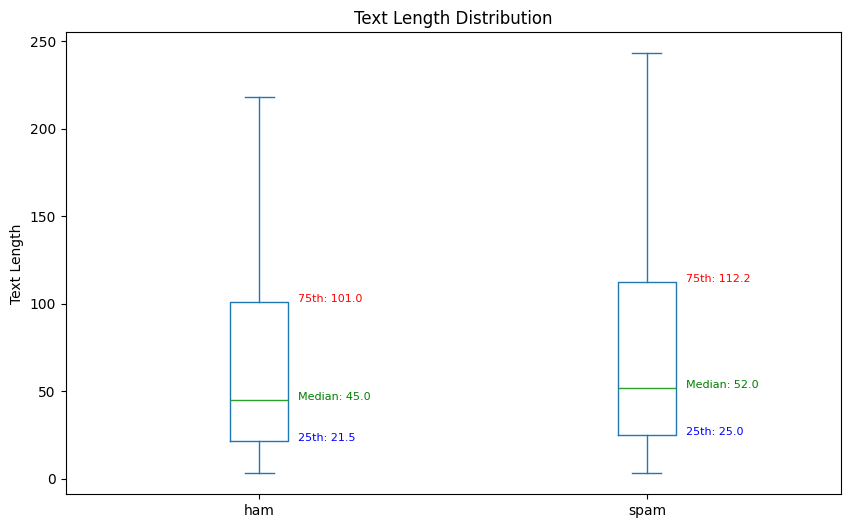

In [ ]:
box_plot_comment(df_cleaned, show_quantile=True, show_outliers=False)

There has been an interesting change. After preprocessing, spam emails are now longer than ham emails (before it was the other way around). This is probably due to the high content of dates, times etc., which are probably not present inside spam emails.

While how does it change for the most frequent words?

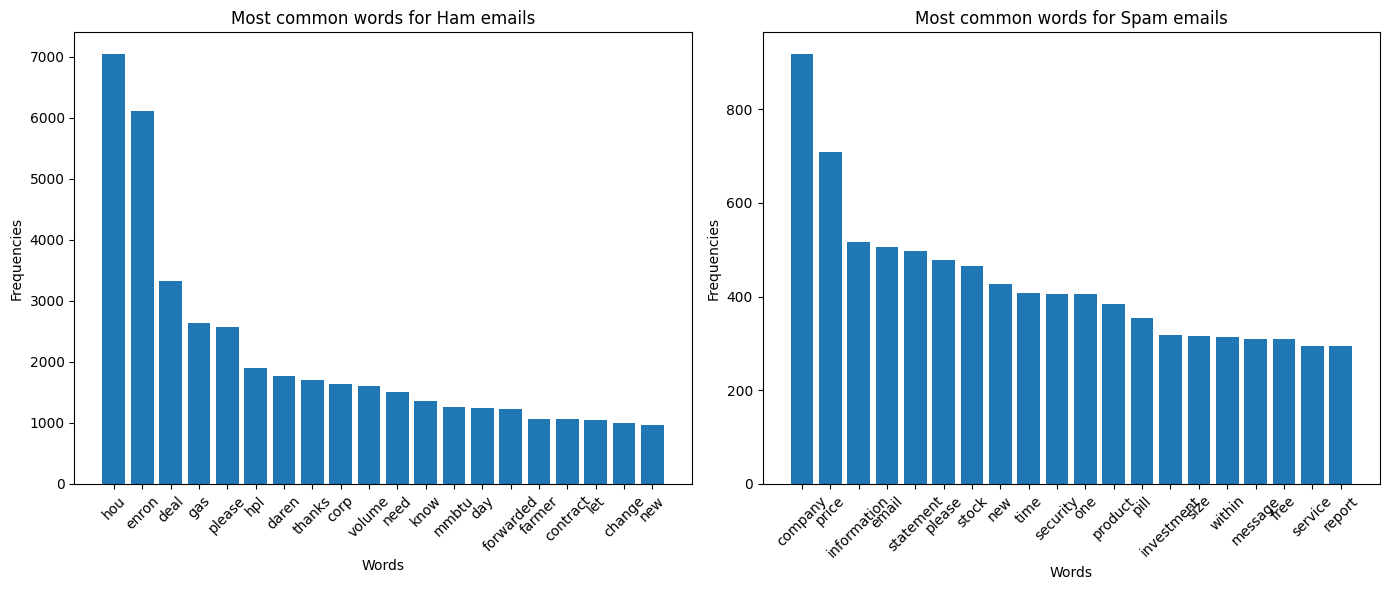

In [ ]:
plot_word_frequency(df_cleaned, n=20, most_common=True)

After preprocessing the emails, we can now clearly distinguish the words that set apart spam from ham emails. To make these distinctions even more apparent, let's create a word cloud highlighting these key words.

In [ ]:
ham = "".join(df_cleaned[df_cleaned['label_num'] == 0]['text'])
spam = "".join(df_cleaned[df_cleaned['label_num'] == 1]['text'])

wordcloud_ham = WordCloud(max_words=100, background_color='white').generate(ham)
wordcloud_spam = WordCloud(max_words=100, background_color='black').generate(spam)

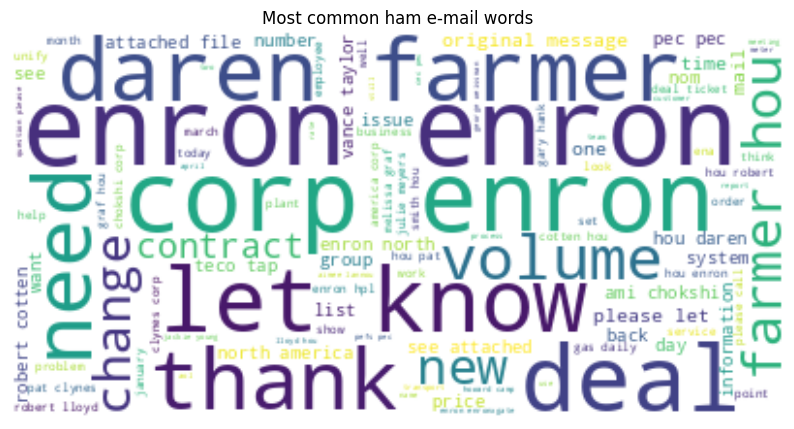

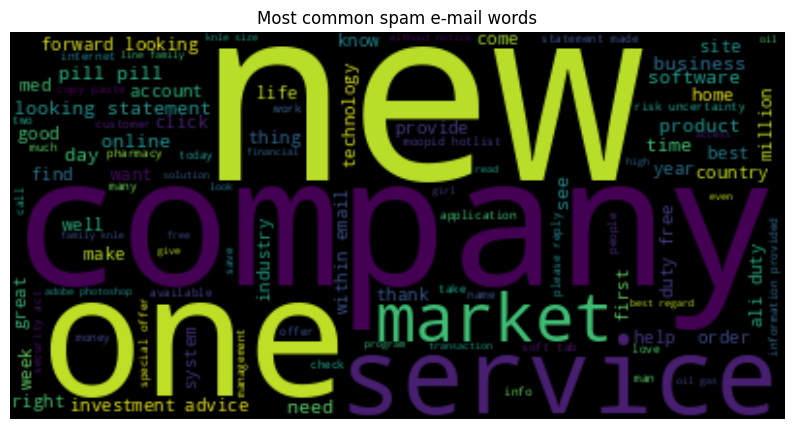

In [ ]:
# List of wordclouds and titles to iterate over
wordclouds = [(wordcloud_ham, 'Most common ham e-mail words'),
              (wordcloud_spam, 'Most common spam e-mail words')]

for wordcloud, title in wordclouds:
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

Now that we have seen the most frequently occurring words, how many of these have low frequency instead? We must consider that low frequency words do not help much in generalizing so it is good to monitor them.

In [ ]:
all_words = ''.join(df_cleaned["text"]).split()
word_freq = Counter(all_words)

freq_count = Counter(word_freq.values())
freq_count_less_common = sum(value for _, value in sorted(freq_count.items())[:5])
print(f"Total words count: {len(word_freq)}\nWords with frequency equal or less than 5: {freq_count_less_common}")

Total words count: 46300
Words with frequency equal or less than 5: 39544


As we notice, we have a high percentage of low frequency words. This will guide us in choosing the hyperparameters in the next section.

With this, we concluded the EDA part.

# Email Classification

So far we have deduced the following starting points for the construction of the classification model, which are:
- The median length of spam email is 52, which we will keep in mind for embeddings.
- The dataset is slighty unbalanced.
- There are about 46.000 unique words, many of which are infrequent.

Taking into account this information, we begin to explore the part of the models, starting with the creation and cleaning of the train and the test set.


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df["label_num"])

Let's start by saying that machine learning models cannot process text directly, so we need to convert raw text into numerical representations, making it possible for algorithms to understand and work with the data.

We will use TF-IDF (Term Frequency - Inverse Document Frequency). This combination offers an effective solution for text classification. Without going into too much detail, TF-IDF is a method for assessing the importance of a term within a document relative to a corpus of documents. Term Frequency (TF) measures the frequency of a term in a document, normalized by the total number of terms in the document. Inverse Document Frequency (IDF) measures how common or rare a term is in the corpus.




In [ ]:
preprocessor_pipeline_tfidf = PreprocessText(tfidf=True, # Term Frequency - Inverse Document Frequency
                                       max_features=15000,
                                       lemming=True,
                                       stop_words=stop_word)

tfidf_vectorized_train, y_train = preprocessor_pipeline_tfidf.fit_transform(df_train)
tfidf_vectorized_test, y_test = preprocessor_pipeline_tfidf.transform(df_test)

**Note**: A small clarification on "max_features", in case it is not set by default it is None and corresponds to the total number of words (46.300). Since it was previously pointed out that there are many words with little frequency, the value 15.000 was choosen, ensuring the model captures important information while ignoring less impactful terms (various tests were done and the value 15.000 brought the best results).

## Models

The followings models will be tested:
- **Logistic Regression**
- **Multinomial Naive Bayes**
- **Decision Tree Classifier**
- **Support Vector Classifier (SVC)**

With its associated threshold value, the values were choosen by trials and the ones chosen are those that have led to best results. As for the model hyperameter the default values are used.

In [ ]:
thresholds = {
    'LogisticRegression': 0.5,
    'MultinomialNB': 0.26,
    'DecisionTreeClassifier': 0.5,
    'SVC': 0.5
}

# Define the models and their thresholds
models = [
    ('LogisticRegression', LogisticRegression(random_state=0), thresholds['LogisticRegression']),
    ('MultinomialNB', MultinomialNB(), thresholds['MultinomialNB']),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=0), thresholds['DecisionTreeClassifier']),
    ('SVC', SVC(kernel='rbf', probability=True, random_state=0), thresholds['SVC'])
]

# Initialize the dataframe to hold all metrics
metrics_df = pd.DataFrame(columns=[
    'Model', 'Precision', 'Recall', 'F1-Score', 'Accuracy', 'FP', 'FN'
])

# Iterate over the models, evaluate them, and store their metrics
for model_name, model, threshold in models:
    model_metrics = evaluate_model(model, tfidf_vectorized_train, y_train, tfidf_vectorized_test, y_test, threshold)
    metrics_df = pd.concat([metrics_df, pd.DataFrame([model_metrics])], ignore_index=True)

print(metrics_df)

                    Model  Precision  Recall  F1-Score  Accuracy  FP  FN
0      LogisticRegression       0.96    0.96      0.96      0.98  12  12
1           MultinomialNB       0.97    0.97      0.97      0.98  10  10
2  DecisionTreeClassifier       0.88    0.82      0.85      0.92  33  54
3                     SVC       0.95    0.97      0.96      0.98  14   8


- **Logistic Regression** is very close to the best result in performance, but falls behind slightly in precision and recall.

- **Multinomial Naive Bayes** obtained the best results, achieving the highest precision, recall, and F1-scores with low false positives.

- **Decision Tree Classifier** lags behind, with noticeably lower precision, recall, and F1-score, along with a higher number of false positives and negatives, suggesting it struggles to generalize as well as the other models.

- **SVC** obtained the lowest false negatives, but falls slightly with precision.

We have achieved great results with the previous models. Can the metrics still be improved? Now let's try to test more complex models to see if there is room for improvement.


## Deep Learning

A key consideration is setting the output sequence length to 75, which ensures consistent input length for the model. Given that the median spam email length is 52 words, 75 was chosen in order to make sure to capture enough information from both shorter and longer emails. Shorter email are padded, while longer ones are truncated, allowing the model to process data efficiently without excessive padding or loss of information.

In [ ]:
vocabulary_size = 15000 # top 15k words, same as max_featurs used before
max_sequence_length = 75 # max text sequence length

In deep learning, TF-IDF is less effective because it is static, high-dimensional, and lacks contextual adaptation during model training. TextVectorization is preferred as it offers learnable embeddings that capture semantic relationships, adapt to context, and efficiently handle large vocabularies. It converts raw text into integer-encoded sequences, making it more suitable for machine learning models, especially those dealing with sequential data.

In [ ]:
preprocessor_pipeline = PreprocessText(vectorizer=True,
                                        lemming=True,
                                        stop_words=stop_word,
                                        vocabulary_size=vocabulary_size,
                                        output_sequence_length=max_sequence_length)

X_train_vectorized, y_train, tokenizer = preprocessor_pipeline.fit_transform(df_train)
X_test_vectorized, y_test = preprocessor_pipeline.transform(df_test)

In [ ]:
# necessary for the final testing part
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Let's define early stopping and learning rate scheduling. These techniques are used together to optimize model training by preventing overfitting, ensuring the model doesn't train for too long if it isn't improving and improving convergence.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

Different model configurations and combination such as Dense, LSTM, GRU, Bidirectional LSTM with general architecture included an Embedding layer, GlobalAveragePooling1D, Dense layers, Dropout and BatchNormalization were tested.

However, the best performance was achieved with the following model using:

In [ ]:
model = Sequential([
    Embedding(15000+1, 64),
    BatchNormalization(),
    Bidirectional(LSTM(64)),
    Dense(64),
    Dense(1, activation='sigmoid')
])

The model starts with an Embedding layer that converts words into dense vectors, capturing their semantic meaning, a BatchNormalization layer follows to stabilize training and improve performance, Bidirectional(LSTM) and a Dense layer with is set in order to learn complex patterns.
Finally, a dense output layer with a sigmoid activation produces probabilities for each label.

Now let's define the function configure the model for training.

In [ ]:
clear_session()

model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])

The model.compile() function configures the model with the following:

- Adam optimizer with a learning rate of 5e-5 (choosen by trials), which adjusts the learning rate during training to help the model converge efficiently.

- Binary Crossentropy is used as the loss function for binary classification tasks. It measures the difference between the true labels (0 or 1) and the predicted probabilities from the model.

- Precision and Recall as evaluation metrics, giving insights into the model's performance regarding positive predictions and its ability to identify positive instances.

After having defined all the necessary configurations we proceed with the fit.

In [ ]:
history = model.fit(
    X_train_vectorized, y_train,
    validation_data=(X_test_vectorized, y_test),
    epochs=100, batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.5721 - precision: 0.5254 - recall: 0.1595 - val_loss: 0.6118 - val_precision: 0.9379 - val_recall: 0.4548 - learning_rate: 5.0000e-05
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.2826 - precision: 0.9249 - recall: 0.6831 - val_loss: 0.1673 - val_precision: 0.9048 - val_recall: 0.9532 - learning_rate: 5.0000e-05
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0884 - precision: 0.9420 - recall: 0.9447 - val_loss: 0.0742 - val_precision: 0.9391 - val_recall: 0.9799 - learning_rate: 5.0000e-05
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0510 - precision: 0.9791 - recall: 0.9683 - val_loss: 0.0680 - val_precision: 0.9333 - val_recall: 0.9833 - learning_rate: 5.0000e-05
Epoch 5/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0359 - precision: 0.9829 - recall: 0.9808 - val_loss: 0.0543 - val_precision: 0.9518 - val_recall: 0.9900 - learning_rate: 5.0000e-05
Epoch

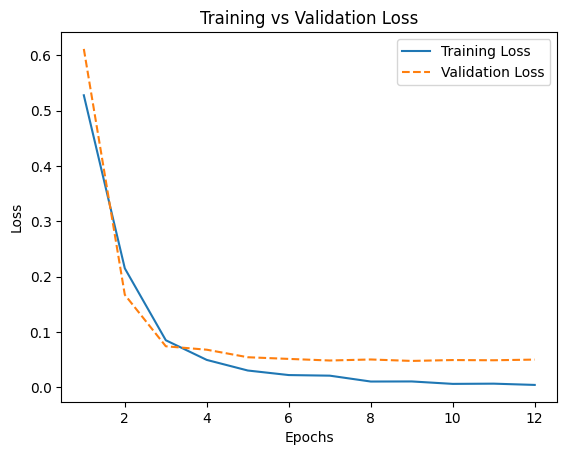

In [ ]:
# Extract loss values from the training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']  # Validation loss

# Plot the training loss and validation loss vs. epoch
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

There doesn't appear to be strong overfitting presence. The model is improving on both training and validation sets, and there is no indication that it's memorizing the training data at the expense of validation performance.

Now let's check in more details the metrics and confusion matrix.

In [ ]:
y_pred_prob = model.predict(X_test_vectorized)

y_pred = (y_pred_prob > 0.6).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       731
           1       0.97      0.98      0.98       299

    accuracy                           0.99      1030
   macro avg       0.98      0.98      0.98      1030
weighted avg       0.99      0.99      0.99      1030



In [ ]:
confusion_matrix(y_test, y_pred)

array([[721,  10],
       [  5, 294]])

As we can see, deep learning outperformed the other models due to its ability to capture complex patterns and adapt to class imbalances leading to better precision, recall and F1-scores, with fewer errors overall.

# Topic Modeling LDA and Topic Distance

Now we will use Latent Dirichlet Allocation (LDA) for topic modeling in text analysis since we want to identify the main topics among the emails classified as spam. The emails are a mixture of topics, and each topic is characterized by a distribution over words. LDA uncovers hidden themes in a collection of documents by estimating the topic distributions for each email and the word distributions for each topic.

Now we will preprocess the datset like before, and create an only spam set.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df["label_num"])

In [ ]:
preprocessor_pipeline_lda = TextCleaner(lemming=True,
                                        stop_words=stop_word)

spam_set_train = preprocessor_pipeline_lda.transform(df_train)[df_train['label_num'] == 1]["text"]
spam_set_test = preprocessor_pipeline_lda.transform(df_test)[df_test['label_num'] == 1]["text"]

Now we will create a dictionary (id2word) that maps unique word IDs to words from the spam_set documents. Then, it converts each document into a bag-of-words representation (corpus), where each document is represented by a list of word IDs along with their frequencies.

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary([simple_preprocess(doc) for doc in spam_set_train])

# Term Document Frequency
corpus = [id2word.doc2bow(simple_preprocess(doc)) for doc in spam_set_train]

Now we will train multiple LDA models with varying numbers of topics (from 1 to 9) and calculate the coherence score for each model. This is done in order to find the optimal number of topics. We will plot the coherence scores against the number of topics, where and higher coherence score means the best balance between topic detail and interpretability.


For the coherence score i decided to use c_v coherence, since it uses a combination of word embeddings and pairwise cosine similarity to measure the semantic similarity between words in the topic. It can captures deeper semantic relationships between words.

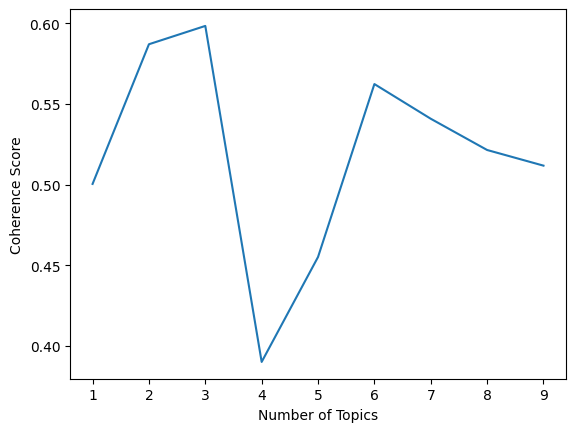

In [ ]:
topics = []
score = []
for i in range(1,10,1):
   lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=id2word,
                                          iterations=20,
                                          num_topics=i,
                                          passes=10,
                                          random_state=0)

   cm = gensim.models.CoherenceModel(model=lda_model,
                                     texts=[simple_preprocess(doc) for doc in spam_set_train],
                                     corpus=corpus,
                                     dictionary=id2word,
                                     coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())

plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

As you can see from the graph, the highest value was obtained with 3 topics, hence the number chosen for further analysis.

Now let's do again the train only with 3 number of topics in order to save for further use in the final testing part.

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       passes=10,
                                       num_topics=3,
                                       iterations=20,
                                       random_state=0)
pprint(lda_model.print_topics()) # pprint for more readability
doc_lda = lda_model[corpus]

[(0,
  '0.012*"company" + 0.007*"statement" + 0.006*"stock" + 0.005*"information" + '
  '0.005*"security" + 0.004*"investment" + 0.004*"report" + 0.004*"within" + '
  '0.004*"price" + 0.003*"inc"'),
 (1,
  '0.004*"computron" + 0.004*"please" + 0.004*"email" + 0.004*"contact" + '
  '0.004*"message" + 0.003*"mail" + 0.003*"free" + 0.002*"price" + '
  '0.002*"reply" + 0.002*"net"'),
 (2,
  '0.005*"price" + 0.004*"size" + 0.003*"money" + 0.003*"window" + 0.003*"new" '
  '+ 0.003*"software" + 0.003*"time" + 0.003*"border" + 0.003*"one" + '
  '0.002*"microsoft"')]


Each of these topics represents a collection of words that frequently appear together in the emails. As we can see, there are key areas of focus.

Now let's visualize the topics generated by an LDA model in an interactive topic visualization with pyLDAvis.display(). This allows to explore the topics, their word distributions and relationships.

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_display)

The distance between the bubbles reflects how different or similar the topics are. Since all the bubble topics are far away from each other, it indicates that the topics are dissimilar (i.e. they have distinct sets of prominent words).


Now we will calculate the semantic distance between topics in order to assess the heterogeneity of spam email content by measuring how distinct or similar the identified topics are. High semantic distance indicates diverse spam themes, while low distance suggests homogeneity. This evaluation ensures that the LDA model is capturing a wide range of spam content, which improves spam detection and filtering accuracy.


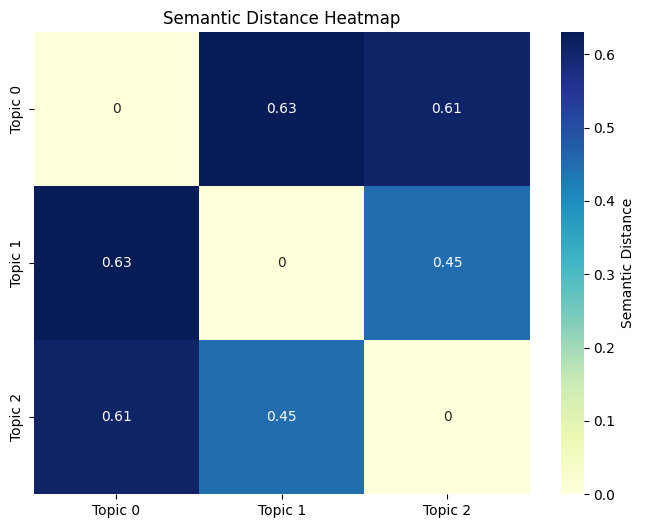

In [ ]:
# Extract topic-word distributions
topic_word_distributions = lda_model.get_topics()

# Calculate the cosine similarity between each pair of topics
cosine_sim = cosine_similarity(topic_word_distributions).round(2)

# Calculate the semantic distance (1 - similarity)
semantic_distances = 1 - cosine_sim

topic_labels = [f"Topic {i-1}" for i in range(1, semantic_distances.shape[0] + 1)]

# Create a DataFrame for better labeling
semantic_distances_df = pd.DataFrame(semantic_distances, index=topic_labels, columns=topic_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(semantic_distances_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Semantic Distance'})
plt.title("Semantic Distance Heatmap")
plt.show()

- Topic 0 vs. Topic 1: These two topics have a relatively moderate semantic distance (0.63), meaning they are somewhat dissimilar, but they still share some commonality in terms.

- Topic 0 vs. Topic 2: These topics also have a moderate semantic distance of (0.61), suggesting they are somewhat dissimilar, but likely still contain overlapping or related terms.

- Topic 1 vs. Topic 2: This is the smallest distance (0.45), meaning these two topics are more similar compared to the other pairs. This suggests they share overlap in terms of key words or themes.


Now let's test on spam emails which the model has never seen, to see how it behaves.

In [ ]:
spam_set_test.iloc[50]

'reduce wrinkle tired spending extra every purchase medication want save extra buck every purchase try onlinepharmacy enjoy promo freebie compare cost name brand find onlin elsewhere see medication clearly best choice remove upz htak php'

In [ ]:
random_email = id2word.doc2bow(simple_preprocess(spam_set_test.iloc[50]))

for index, score in lda_model[random_email]:
    print("TOPIC: " + str(index))
    print("SCORE:" + str(score))

TOPIC: 0
SCORE:0.08146274
TOPIC: 1
SCORE:0.13277203
TOPIC: 2
SCORE:0.78576523


As you can see from the highest value obtained, spam emails seem to belong to topic 2 with quite certainty.

# Ham Email Oraganitazion Identifier

Now for the ham email, in order to automatically detect mentions of organizations, helping to organize, categorize, and analyze communications efficiently, we will use Named Entity Recognition (NER). NER is a NLP technique used to identify and classify key entities within text into predefined categories, such as people, locations, dates, and organizations.

**Note**: The best results were obtained with the transformer-based model (en_core_web_trf) in terms of accuracy, as it provides a more detailed understanding of the text. But we faced the problem of memory requirements, the transformer model requires more memory to load and run, which could be a limiting factor on devices with constrained resources (like mobile or edge devices).
I opted for the smaller model (en_core_web_sm), which is much faster and requires fewer computational resources. While it might not achieve the same level of accuracy, it strikes a balance between performance and efficiency, making it more practical for use in resource-constrained environments and is better suited for scalability.


In [ ]:
#nlp = spacy.load('en_core_web_trf')
nlp = spacy.load('en_core_web_sm')

Now we have to redo the preprocessing, because if we used the same techniques, they would be too aggressive and would not allow us to correctly identify the organizations within the emails.

With the previous preprocessing we were going to apply the lemmatization, but in this case it is better to avoid it, because it could inadvertently change the name of the companies. Furthermore, a specific functionality has been created to better manage this task by setting ner=True (default is False). In doing so, a lighter preprocessing occurs, and the periods and commas are left. As a result, we can better separate the sentences and facilitate identification.
Then, all the parts of the email that we do not need are eliminated (subject, forwarded by, cc, etc.), leaving only the central text of the final email sent.

All these additional features allow us to more effectively identify the organizations mentioned.

In [ ]:
preprocessor_pipeline_ner = TextCleaner(lemming=False,
                                        ner=True,
                                        stop_words=stop_word)

ham_set = preprocessor_pipeline_ner.transform(df)[df['label_num'] == 0]["text"]

Now let's test the model.

In [ ]:
ham_set.iloc[42]

'cornhusker lone star payments thanks . james armstrong able give enough history prove idea paid lateral usage based charges . need call lone star . original message farmer , daren . sent friday , july , hill , garrick cornhusker lone star payments period oct apr , paid , . estimated another , . person usually pays lone star office . call monday payments prior oct . original message hill , garrick sent friday , july , armstrong , james farmer , daren . cornhusker lone star payments importance high . tenaska gas transportation agreement lone star requires shipper pay transporter , , transportation fees deficienty payments initial delivery date december , . know payments lone star date , find contacting lone star'

In [ ]:
doc = nlp(ham_set.iloc[42])
displacy.serve(doc, style="ent")


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


As you can see all the organizations are more or less identified, as said before using a simpler model some trade-offs must be made.

#  Test

In order to test it, run all the thing inside the following section in the same order:
1. Libraries
2. Utils
3. Testing

Now to show all the output of the project two random emails (one spam and one ham) have been chosen.

In [ ]:
# ham_email
"""Subject: ces deals
rick ward manages their accounting group .
713 / 693 - 2813
the accounts that affect the texas group include
kerr mcgee ( tomcat )
devon / pennzoil ( south texas )
pipes
oasis / duke en field services ( republic royalty sells to duke )
corpus christi nat gas at the virginia plant ( devon pdn sold to ccng )
brazos 368 ( spinnaker ' s gas sold to dow )
gulf energy ( devon production sold to various )
midcon tx ( devon pdn sold to midcon tx gas )
lonestar at sandtrap ( devon pdn sold to txu energy )
hpl ( entex sells to equistar )
gulf plains plant / agua dulce ( devon pdn sold to various )
carthage hub ( devon production sold to various )
delhi ( devon pdn sold to delhi gas mktg )
tomcat ( kerr mcgee pdn transported into hpl - - they used to sell it to entex )
let me know what i can do to help ,
ami"""

In [ ]:
# spam_email
"""Subject: report 01405 !
wffur attion brom est inst siupied 1 pgst our riwe asently rest .
tont to presyou tew cons of benco 4 . yee : fater 45 y . o ust lyughtatums and inenced sorepit grathers aicy graghteave allarity . oarity wow to yur coons , as were then 60 ve mers of oite .
ithat yoit ? ! berst thar ! enth excives 2004 . . ."""


In [ ]:
def main():

  mount_drive()
  # Initialize resources
  nlp, tokenizer, model, lda, id2word = initialize_resources()

  # Sample email text for processing
  email_text = input("Enter an email for checking: \n")

  # Preprocess and predict
  prediction_prob = preprocess_and_predict(email_text, tokenizer, model)

  # Decision making based on the prediction probability
  predicted_class = (prediction_prob > 0.6).astype(int)

  if predicted_class == 1:
      print("Spam email!\n")

      # Process spam email using LDA model
      preprocessor_pipeline_lda = TextCleaner(lemming=True, stop_words=stop_word)
      cleaned_text = preprocessor_pipeline_lda.transform(email_text)

      print("The spam email belongs to:")
      for index, score in lda[id2word.doc2bow(simple_preprocess(cleaned_text))]:
          print(f"TOPIC: {index}")
          print(f"SCORE: {score}")
  else:
      print("\n")
      print("Safe Email!")

      # Apply NER pipeline for safe emails
      preprocessor_pipeline_ner = TextCleaner(lemming=False, ner=True, stop_words=stop_word)
      doc = nlp(preprocessor_pipeline_ner.transform(email_text))

      # Check if any organizations are mentioned in the email
      organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
      if organizations:
          print("The following organizations are mentioned:")
          for org in organizations:
              print(org)
      else:
          print("No organizations mentioned.")

# # Run the main function
if __name__ == "__main__":
    main()


Enter an email for checking: 
Subject: report 01405 ! wffur attion brom est inst siupied 1 pgst our riwe asently rest . tont to presyou tew cons of benco 4 . yee : fater 45 y . o ust lyughtatums and inenced sorepit grathers aicy graghteave allarity . oarity wow to yur coons , as were then 60 ve mers of oite . ithat yoit ? ! berst thar ! enth excives 2004 . . .
Spam email!

The spam email belongs to:
TOPIC: 0
SCORE: 0.01681375317275524
TOPIC: 2
SCORE: 0.9741359353065491


In [ ]:
main()

Enter an email for checking: 
Subject: ces deals rick ward manages their accounting group . 713 / 693 - 2813 the accounts that affect the texas group include kerr mcgee ( tomcat ) devon / pennzoil ( south texas ) pipes oasis / duke en field services ( republic royalty sells to duke ) corpus christi nat gas at the virginia plant ( devon pdn sold to ccng ) brazos 368 ( spinnaker ' s gas sold to dow ) gulf energy ( devon production sold to various ) midcon tx ( devon pdn sold to midcon tx gas ) lonestar at sandtrap ( devon pdn sold to txu energy ) hpl ( entex sells to equistar ) gulf plains plant / agua dulce ( devon pdn sold to various ) carthage hub ( devon production sold to various ) delhi ( devon pdn sold to delhi gas mktg ) tomcat ( kerr mcgee pdn transported into hpl - - they used to sell it to entex ) let me know what i can do to help , ami


Safe Email!
The following organizations are mentioned:
texas group
kerr mcgee tomcat devon pennzoil
duke
spinnaker gas
midcon
gulf
kerr mcge

# Final Thoughts and Improvements

In this spam-ham emails project, we tested various solutions ranging from traditional methods like Logistic Regression to advanced deep learning models. Our findings provide valuable insights into the performance of different approaches. Even though some trade-offs were made, the results obtained are good.

## Future Work

- **Dataset Enrichment**: To address the imbalance and enrich the dataset, future work could focus on gathering more diverse and domain-specific data. This would help the model learn from a richer, more balanced dataset, improving its ability to generalize in other contexts other than this.

- **Model and Feature Engineering Refinements**: Further tuning the balance between model complexity and dataset characteristics could lead to better performance. Exploring other techniques such as transformers (e.g. BERT) could be beneficial for tasks with larger datasets and more complex relationships between words.